In [2]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from pathlib import Path
# from sklearn.metrics import ConfusionMatrixDisplay

from ba_dev.utils import load_path_yaml
from ba_dev.eval_helpers import *

paths = load_path_yaml('../../data/path_config.yml')

set_custom_plot_style()
cm = 1 / 2.54

export = True

In [3]:
# # calculating the balanced accuracy score for all runs
# bal_acc = evaluate_all_runs(
#     path_to_runs=paths['complete_models'],
#     metrics='balanced_accuracy_score',
#     )

# bal_acc.to_csv('bal_acc.csv', index=False)

bal_acc = pd.read_csv('bal_acc.csv')

In [4]:
# Balanced accuracy Table for all models
########################################################################################################################
table_name = 'bal_acc_by_model'
caption = r'Balanced accuracy of all models -- shown as mean ± standard deviation.'
########################################################################################################################

summary_bal_acc = (
    bal_acc
    .groupby(['model_name', 'pretrained'])
    .agg(
        trainable_params=('trainable_params', 'first'),
        img_score_mean=('img_score', 'mean'),
        img_score_std =('img_score', 'std'),
        seq_score_mean=('seq_score', 'mean'),
        seq_score_std =('seq_score', 'std'),
    )
    .reset_index()
    .sort_values(
        by=['pretrained', 'trainable_params'],
        ascending=[False, True]
    )
    )

for scope in ['img', 'seq']:
    mean_str = summary_bal_acc[f'{scope}_score_mean'].map("{:.4f}".format)
    std_str  = summary_bal_acc[f'{scope}_score_std'].map("{:.3f}".format)
    summary_bal_acc[f'bal_acc_{scope}'] = mean_str + ' ± ' + std_str

table = (
        summary_bal_acc[
            ['model_name', 'pretrained', 'trainable_params', 'bal_acc_img', 'bal_acc_seq']
        ]
        .rename(columns={
            'model_name': 'Model',
            'pretrained': 'Pretrained',
            'trainable_params': 'Params (M)',
            'bal_acc_img': r'Image BA-Score',
            'bal_acc_seq': r'Sequence BA-Score'
        }))

table['Params (M)'] = (table['Params (M)'] / 1_000_000).astype(int)
table['Pretrained'] = table['Pretrained'].map({True: 'Yes', False: 'No'})
table['Model'] = table['Model'].str.replace('_', r'\_')

latex = table.to_latex(
    index=False,
    column_format='l c r c c',
    escape=False,
    caption=caption,
    label=f'tab:{table_name}',
    )

latex = latex.replace(r'\begin{table}', r'\begin{table}[H]', 1)

lines = latex.splitlines()

for i, line in enumerate(lines):
    if '& No &' in line:
        split_index = i
        break

new_lines = lines[:split_index] + ['\midrule'] + lines[split_index:]

latex = "\n".join(new_lines)

print(latex)

# if export:
with open(paths['table'] / f'{table_name}.tex', 'w') as f:
    f.write(latex)


\begin{table}[H]
\caption{Balanced accuracy of all models -- shown as mean ± standard deviation.}
\label{tab:bal_acc_by_model}
\begin{tabular}{l c r c c}
\toprule
Model & Pretrained & Params (M) & Image BA-Score & Sequence BA-Score \\
\midrule
efficientnet\_b0 & Yes & 4 & 0.9921 ± 0.004 & 0.9947 ± 0.002 \\
densenet169 & Yes & 12 & 0.9904 ± 0.004 & 0.9939 ± 0.002 \\
resnet50 & Yes & 23 & 0.9899 ± 0.004 & 0.9934 ± 0.002 \\
vit\_b\_16 & Yes & 85 & 0.9885 ± 0.005 & 0.9933 ± 0.002 \\
\midrule
efficientnet\_b0 & No & 4 & 0.9856 ± 0.005 & 0.9898 ± 0.003 \\
densenet169 & No & 12 & 0.9863 ± 0.006 & 0.9899 ± 0.002 \\
resnet50 & No & 23 & 0.9850 ± 0.004 & 0.9888 ± 0.003 \\
vit\_b\_16 & No & 85 & 0.9767 ± 0.006 & 0.9856 ± 0.004 \\
\bottomrule
\end{tabular}
\end{table}


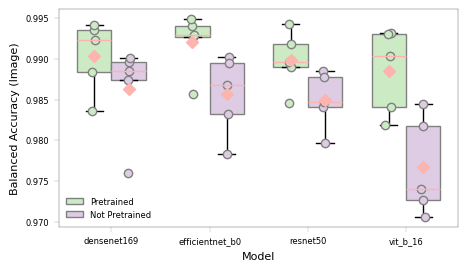

In [6]:
# Box Plot for Balanced Accuracy by Model and Pretrained Status
########################################################################################################################
fig_name = 'bal_acc_img.pdf'
fig_size = (12*cm,7*cm)
########################################################################################################################

models = sorted(bal_acc['model_name'].unique())
n = len(models)
x = range(n)
width = 0.35

# collect your two series
data_pre = [
    bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score'] 
    for m in models
]
data_no = [
    bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score'] 
    for m in models
]

cmap = plt.get_cmap('Pastel1')
color_pre = cmap(2)
color_no  = cmap(3)
red = cmap(0)

plt.figure(figsize=fig_size)

medianprops = dict(linewidth=1, color=red)

meanprops = dict(
                marker='D',
                markeredgecolor=red,
                markerfacecolor=red,
                markersize=6
                )

flierprops = dict(marker='', linestyle='none')

# draw the boxplots
bp_pre = plt.boxplot(
    data_pre,
    positions=[i - width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
)
bp_no = plt.boxplot(
    data_no,
    positions=[i + width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
)

# apply facecolors and a subtle edge
for box in bp_pre['boxes']:
    box.set_facecolor(color_pre)
    box.set_edgecolor('gray')
for box in bp_no['boxes']:
    box.set_facecolor(color_no)
    box.set_edgecolor('gray')

# axes labels
plt.xticks(x, models, ha='center')
plt.xlabel('Model')
plt.ylabel('Balanced Accuracy (Image)')

# legend with box patches!
legend_handles = [
    Patch(facecolor=color_pre, edgecolor='gray', label='Pretrained'),
    Patch(facecolor=color_no,  edgecolor='gray', label='Not Pretrained')
]
plt.legend(handles=legend_handles, frameon=False, loc='lower left')

for i, m in enumerate(models):
    # pretrained points
    y_pre = bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score']
    x_pre = np.random.normal(i - width/2, width*0.05, size=len(y_pre))
    plt.scatter(x_pre, y_pre, color=color_pre, edgecolor='gray', zorder=2)

    # non-pretrained points
    y_no  = bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score']
    x_no  = np.random.normal(i + width/2, width*0.05, size=len(y_no))
    plt.scatter(x_no, y_no, color=color_no,  edgecolor='gray', zorder=2)


plt.tight_layout()
if export:
    plt.savefig(paths['figures'] / fig_name, dpi=300)
plt.show()

In [8]:
0.00001

1e-05

In [9]:
10**-5

1e-05